In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import vincenty
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
import eli5
from eli5.sklearn import PermutationImportance
from skopt.space import Real
import warnings
warnings.filterwarnings("ignore")

import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
%matplotlib inline
import nltk
from nltk.corpus import stopwords as stp
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = newstopwords = [word for word in stopwords if word not in ['not', 'no', 'can', 'don', 't','https','RT']]

##VADER has a lot of advantages over traditional methods of Sentiment Analysis, including:
It works exceedingly well on social media type text, yet readily generalizes to multiple domains
It doesn’t require any training data but is constructed from a generalizable, valence-based, human-curated gold standard sentiment lexicon
It is fast enough to be used online with streaming data, and
It does not severely suffer from a speed-performance tradeoff.


In [99]:
#Reading CSV files into dataFrames

In [100]:
reviews_path = '/Users/baskar/Documents/ml/Syracuse/IST-718/IST718FinalProject-master 2/'
rotten_reviews =  pd.read_csv(reviews_path + 'rottentomato.csv')
tweet_reviews = pd.read_csv(reviews_path + 'tweets.csv')

In [101]:
#Initial look of the reviews in Twitter reviews  shows that it needed little cleanup 

In [102]:
#Cleaned reviews

In [103]:
tweet_reviews['clean_text']=(tweet_reviews['clean_text']
.str.replace('RT','')
.str.replace('\n\n','')
.str.replace('\n','')
.str.replace('@Marvel_Informer:','')
.str.replace('@RobertDowneyJr:','') 
.str.replace('https','') 
.str.replace('brutasha_endgam Here', '') 
.str.replace('[^\w\s]','')                           
.str.replace('@brutasha_endgam:', ''))

In [104]:

tweet_reviews['clean_text']


0          s  nt turn green   I wo nt  Because always m...
1        AvengersAgeOfUltron easy watch events infinity...
2          s  nt turn green   I wo nt  Because always m...
3          s  nt turn green   I wo nt  Because always m...
4         Marvel_Informer Who else got goosebumps lines...
5          s  nt turn green   I wo nt  Because always m...
6         RobertDowneyJr A whole lotta sexy  chrishemsw...
7         RobertDowneyJr Civil War AgeofUltron PressTou...
8         RobertDowneyJr We want YOU Team AgeOfUltron P...
9         RobertDowneyJr Civil War AgeofUltron PressTou...
10        _Selfish_Guy_ franchise installment grossed 1...
11         s  nt turn green   I wo nt  Because always m...
12        _Selfish_Guy_ franchise installment grossed 1...
13         s  nt turn green   I wo nt  Because always m...
14        _Selfish_Guy_ franchise installment grossed 1...
15       franchise installment grossed 1 billion TheAve...
16         s  nt turn green   I wo nt  Because always m.

In [105]:
tweet_reviews.drop(tweet_reviews.head(40).index, inplace=True)

In [106]:
tweet_reviews['clean_text'].sample(10, random_state=42)

6965     Bought first funkopop lol also infinitygauntle...
14006     Bosslogic Have nt done rumour casting awhile ...
4854      Russo_Brothers Go see 4th time weekend Becaus...
7086     Destiny arrive I obtained infinity stones life...
13101    blankcheckpod davidlsims I think called Peter ...
11096     nickirockster  Truth nothing Truth  JayZ quot...
2548     Aquaman Mera couple monarchs I talked day phoe...
26769    Wolverine Minion Mash Up Wolvenion minions min...
23281     moviesnowtv Our Spidey senses spiraling contr...
16421    Tomorrow Member Appreciation Day SFMagicMounta...
Name: clean_text, dtype: object

In [107]:
rotten_reviews['text'].sample(10, random_state=42)

5671    The movie generates a decent amount of good wi...
5771    It's checklist mythology, but thankfully serve...
2111    If Infinity War were the Second World War, I'd...
6660    The Force Awakens is as good as it is bad; flu...
5228    Functioning both as a standard, predictable, b...
940     [Peyton Reed] keeps it all breezy, light and l...
7703    It's the first Thor movie that will make you w...
3542    If there's any justice, dawning or otherwise, ...
2184    Epic in scope and a stunning achievement in bl...
7279    Disney found a true "Star Wars" champion in Jo...
Name: text, dtype: object

In [108]:
rotten_reviews.Movie.unique()

array(['AgeofUltron', 'Antman', 'Antmanthewasp', 'Aquaman',
       'AvengersEndgame', 'AvengersInfinityWar', 'BlackPanther',
       'CivilWar', 'DawnofJustice', 'DoctorStrange',
       'GuardiansoftheGalaxy', 'JusticeLeague', 'RogueOne', 'Shazam',
       'Solo', 'SpidermanHomecoming', 'SuicideSquad', 'TheForceAwakens',
       'TheLastJedi', 'ThorRagnarok', 'WonderWoman'], dtype=object)

In [109]:
tweet_reviews.Movie.unique()

array(['AgeofUltron', 'AntMantheWasp', 'Antman', 'Aquaman',
       'AvengersEndgame', 'AvengersInfinityWar', 'BlackPanther',
       'CivilWar', 'DawnofJustice', 'DoctorStrange',
       'GuardiansoftheGalaxy', 'JusticeLeague', 'RogueOne', 'Shazam',
       'Solo', 'SpidermanFarfromhome', 'SpidermanHomecoming',
       'SuicideSquad', 'TheForceAwakens', 'TheLastJedi', 'ThorRagnarok',
       'WonderWoman'], dtype=object)

In [110]:
tweet_reviews.isnull().sum().sort_values(ascending=False).head(20)

place_coord_boundaries    27798
possibly_sensitive        14443
place                      8795
user_mentions              7101
hashtags                   4991
original_author              18
lang                          9
retweet_count                 9
favorite_count                9
subjectivity                  9
polarity                      9
sentiment                     9
clean_text                    9
created_at                    0
id                            0
FileName                      0
source                        0
original_text                 0
Movie                         0
dtype: int64

In [111]:
rotten_reviews.isnull().sum().sort_values(ascending=False).head(20)

text        1
Field_1     0
FileName    0
Movie       0
dtype: int64

In [112]:
tweet_reviews.drop(axis=1, columns=['place_coord_boundaries', 'possibly_sensitive', 'place','user_mentions','hashtags','original_author','retweet_count','favorite_count','lang'], inplace=True)

In [113]:
tweet_reviews.isnull().sum().sort_values(ascending=False).head(20)

subjectivity     9
polarity         9
sentiment        9
clean_text       9
FileName         0
original_text    0
source           0
created_at       0
id               0
Movie            0
dtype: int64

In [114]:
tweet_reviews['clean_text']

40                              return AvengersAgeOfUltron
41        Fury son bitch   Ooh kiss mother mouth  lAnGu...
42             fuRy YoU sOn Of A BitCh AvengersAgeOfUltron
43        Marvel_Informer Who else got goosebumps lines...
44        Marvel_Informer Who else got goosebumps lines...
45        RobertDowneyJr Civil War AgeofUltron PressTou...
46                    Ultron taki mood AvengersAgeOfUltron
47                     wakanda forever AvengersAgeOfUltron
48         s  nt turn green   I wo nt  Because always m...
49        Marvel_Informer Who else got goosebumps lines...
50        Marvel_Informer Who else got goosebumps lines...
51         s  nt turn green   I wo nt  Because always m...
52         s  nt turn green   I wo nt  Because always m...
53       Here s  nt turn green   I wo nt  Because alway...
54        CobwebRed avengersageofultron  Tony How guys ...
55       Al  most  Like far cosplay cosplayer captainam...
56        Marvel_Informer Who else got goosebumps lines.

In [115]:
tweet_reviews.dropna(subset=['clean_text'], how='any', axis=0, inplace=True)

tweet_reviews.clean_text.isnull().sum()

0

In [116]:
tweet_reviews.clean_text

40                              return AvengersAgeOfUltron
41        Fury son bitch   Ooh kiss mother mouth  lAnGu...
42             fuRy YoU sOn Of A BitCh AvengersAgeOfUltron
43        Marvel_Informer Who else got goosebumps lines...
44        Marvel_Informer Who else got goosebumps lines...
45        RobertDowneyJr Civil War AgeofUltron PressTou...
46                    Ultron taki mood AvengersAgeOfUltron
47                     wakanda forever AvengersAgeOfUltron
48         s  nt turn green   I wo nt  Because always m...
49        Marvel_Informer Who else got goosebumps lines...
50        Marvel_Informer Who else got goosebumps lines...
51         s  nt turn green   I wo nt  Because always m...
52         s  nt turn green   I wo nt  Because always m...
53       Here s  nt turn green   I wo nt  Because alway...
54        CobwebRed avengersageofultron  Tony How guys ...
55       Al  most  Like far cosplay cosplayer captainam...
56        Marvel_Informer Who else got goosebumps lines.

In [117]:
rotten_reviews.dropna(subset=['text'], how='any', axis=0, inplace=True)

rotten_reviews.text.isnull().sum()

0

In [118]:
# calculates compound sentiment polarity of the sentence for Twitter Reviews
vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

In [119]:
tweet_reviews['polarity'] = tweet_reviews.clean_text.map(vader_polarity_compound)
tweet_reviews.to_csv('reviews_Polarity.csv',sep=',', header='TRUE')

In [120]:
# calculates compound sentiment polarity of the sentence for Rotten Tomato Reviews
vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

In [121]:
rotten_reviews['polarity'] = rotten_reviews.text.map(vader_polarity_compound)
rotten_reviews.to_csv('rotten_reviews_Polarity.csv',sep=',', header='TRUE')


In [122]:
tweet_polarity_reviews=pd.read_csv('reviews_Polarity.csv')
tweet_polarity_reviews.head(5)

,Unnamed: 0,Movie,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,FileName
0,40,AgeofUltron,1132028807844716545,Fri May 24 21:01:14 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Avengers will return.\n#Avengers\n#AvengersAge...,return AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,AgeofUltron_data
1,41,AgeofUltron,1132022251954552833,Fri May 24 20:35:11 +0000 2019,"<a href=""http://twitter.com/download/android"" ...","""Fury, you son of a bitch""\n""Ooh, you kiss you...",Fury son bitch Ooh kiss mother mouth lAnGu...,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.6908,0.0,AgeofUltron_data
2,42,AgeofUltron,1132021647446335488,Fri May 24 20:32:47 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",fuRy YoU sOn Of A BitCh #AvengersAgeOfUltron,fuRy YoU sOn Of A BitCh AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.8176,0.0,AgeofUltron_data
3,43,AgeofUltron,1132013380825493505,Fri May 24 19:59:56 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,AgeofUltron_data
4,44,AgeofUltron,1132006405848883200,Fri May 24 19:32:13 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,AgeofUltron_data


In [123]:
rotten_polarity_reviews=pd.read_csv('rotten_reviews_Polarity.csv')
rotten_polarity_reviews.head(5)

,Unnamed: 0,Movie,FileName,Field_1,text,polarity
0,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382
1,1,AgeofUltron,AgeofUltron_rm,1,"""Avengers: Age of Ultron"" is a sometimes daffy...",0.8813
2,2,AgeofUltron,AgeofUltron_rm,2,"More does not necessarily equal better; here, ...",-0.4031
3,3,AgeofUltron,AgeofUltron_rm,3,"The sharp, interpersonal dramedy that made the...",-0.1655
4,4,AgeofUltron,AgeofUltron_rm,4,"For the most part, ""Avengers: Age of Ultron"" i...",0.0000


In [ ]:
Plotting the histogram of review intensities reveals the following peculiarities:
huge asymmetry between positive and negative reviews, only very few of the reviews (or close to 5%) are close to maximally positive (polarity > 0.92);
prominent peak of ~10k 'neutral' reviews.

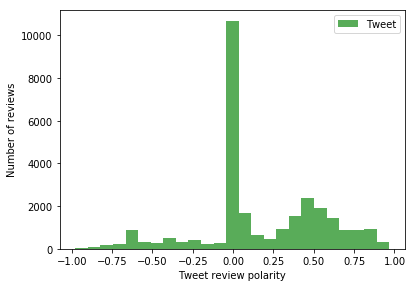

In [124]:
plt.hist(tweet_polarity_reviews.polarity, bins=25, color='g', alpha=0.65)

plt.legend(['Tweet'])
plt.xlabel('Tweet review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('tweet_polarity_reviews.png')

Importantly, very small fraction (< 5%) of all reviews of our interest are negative:

In [125]:
(tweet_polarity_reviews.polarity.values < -0.05).mean()

0.13234362907197636

Let us look on their distribution in more details:

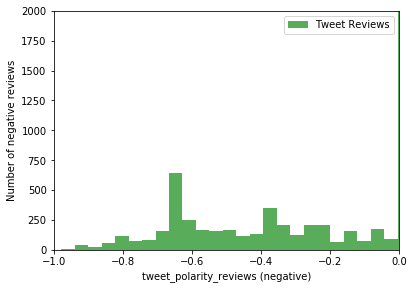

In [126]:
plt.hist(tweet_polarity_reviews.polarity, bins=50, color='g', alpha=0.65)
plt.legend(['Tweet Reviews'])
plt.xlim([-1.00, 0.00])
plt.ylim([0, 2000])
plt.xlabel('tweet_polarity_reviews (negative)')
plt.ylabel('Number of negative reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('tweet_negative_polarity.png')

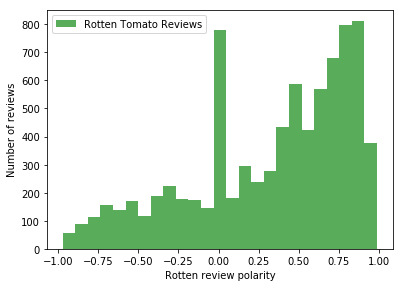

In [127]:
plt.hist(rotten_polarity_reviews.polarity, bins=25, color='g', alpha=0.65)

plt.legend(['Rotten Tomato Reviews'])
plt.xlabel('Rotten review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('Rotten_polarity_reviews.png')

In [128]:
(rotten_polarity_reviews.polarity.values < -0.05).mean()

0.2115478515625

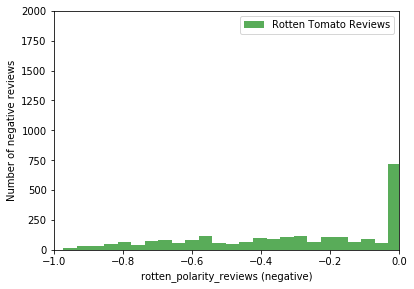

In [129]:
plt.hist(rotten_polarity_reviews.polarity, bins=50, color='g', alpha=0.65)
plt.legend(['Rotten Tomato Reviews'])
plt.xlim([-1.00, 0.00])
plt.ylim([0, 2000])
plt.xlabel('rotten_polarity_reviews (negative)')
plt.ylabel('Number of negative reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('rotten_negative_polarity.png')

In [148]:
#Merging two Polarity review dataframes based on movie with a left join
combined_reviews = pd.merge(left=rotten_polarity_reviews,right=tweet_polarity_reviews, how='left', left_on='Movie', right_on='Movie')
combined_reviews

,Unnamed: 0_x,Movie,FileName_x,Field_1,text,polarity_x,Unnamed: 0_y,id,created_at,source,original_text,clean_text,sentiment,polarity_y,subjectivity,FileName_y
0,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,40.0,1132028807844716545,Fri May 24 21:01:14 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Avengers will return.\n#Avengers\n#AvengersAge...,return AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data
1,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,41.0,1132022251954552833,Fri May 24 20:35:11 +0000 2019,"<a href=""http://twitter.com/download/android"" ...","""Fury, you son of a bitch""\n""Ooh, you kiss you...",Fury son bitch Ooh kiss mother mouth lAnGu...,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.6908,0.000000,AgeofUltron_data
2,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,42.0,1132021647446335488,Fri May 24 20:32:47 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",fuRy YoU sOn Of A BitCh #AvengersAgeOfUltron,fuRy YoU sOn Of A BitCh AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.8176,0.000000,AgeofUltron_data
3,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,43.0,1132013380825493505,Fri May 24 19:59:56 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data
4,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,44.0,1132006405848883200,Fri May 24 19:32:13 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data
5,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,45.0,1132001370876211200,Fri May 24 19:12:13 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @RobertDowneyJr: Civil War? #AgeofUltron #P...,RobertDowneyJr Civil War AgeofUltron PressTou...,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.5994,0.000000,AgeofUltron_data
6,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,46.0,1131998775675969537,Fri May 24 19:01:54 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Ultron to taki mood.\n#Avengers\n#AvengersAgeO...,Ultron taki mood AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data
7,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,47.0,1131997693134417920,Fri May 24 18:57:36 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",wakanda forever #AvengersAgeOfUltron,wakanda forever AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data
8,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,48.0,1131994608223674368,Fri May 24 18:45:20 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @brutasha_endgam: Here's \n\n ...,s nt turn green I wo nt Because always m...,"Sentiment(polarity=-0.2, subjectivity=0.175)",-0.2960,0.175000,AgeofUltron_data
9,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,49.0,1131993519386710016,Fri May 24 18:41:01 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data


In [149]:
#Since both the datasets had reviews ,had to create a new Revies column combining text and clean_text from Rotten Tomatoes and
#Twitter respectively
combined_reviews["Reviews"] = combined_reviews["text"].map(str) + combined_reviews["clean_text"]

In [150]:
combined_reviews


,Unnamed: 0_x,Movie,FileName_x,Field_1,text,polarity_x,Unnamed: 0_y,id,created_at,source,original_text,clean_text,sentiment,polarity_y,subjectivity,FileName_y,Reviews
0,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,40.0,1132028807844716545,Fri May 24 21:01:14 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Avengers will return.\n#Avengers\n#AvengersAge...,return AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
1,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,41.0,1132022251954552833,Fri May 24 20:35:11 +0000 2019,"<a href=""http://twitter.com/download/android"" ...","""Fury, you son of a bitch""\n""Ooh, you kiss you...",Fury son bitch Ooh kiss mother mouth lAnGu...,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.6908,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
2,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,42.0,1132021647446335488,Fri May 24 20:32:47 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",fuRy YoU sOn Of A BitCh #AvengersAgeOfUltron,fuRy YoU sOn Of A BitCh AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.8176,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
3,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,43.0,1132013380825493505,Fri May 24 19:59:56 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
4,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,44.0,1132006405848883200,Fri May 24 19:32:13 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @Marvel_Informer: Who else got goosebumps f...,Marvel_Informer Who else got goosebumps lines...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
5,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,45.0,1132001370876211200,Fri May 24 19:12:13 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @RobertDowneyJr: Civil War? #AgeofUltron #P...,RobertDowneyJr Civil War AgeofUltron PressTou...,"Sentiment(polarity=0.0, subjectivity=0.0)",-0.5994,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
6,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,46.0,1131998775675969537,Fri May 24 19:01:54 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Ultron to taki mood.\n#Avengers\n#AvengersAgeO...,Ultron taki mood AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
7,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,47.0,1131997693134417920,Fri May 24 18:57:36 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",wakanda forever #AvengersAgeOfUltron,wakanda forever AvengersAgeOfUltron,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.000000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
8,0,AgeofUltron,AgeofUltron_rm,0,"Fans of the franchise will be pleased, but tho...",0.2382,48.0,1131994608223674368,Fri May 24 18:45:20 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @brutasha_endgam: Here's \n\n ...,s nt turn green I wo nt Because always m...,"Sentiment(polarity=-0.2, subjectivity=0.175)",-0.2960,0.175000,AgeofUltron_data,"Fans of the franchise will be pleased, but tho..."
9,0,AgeofUltron,AgeofUltron_rm,0,"Fans of 

In [47]:
#Creating WordClouds on Reviews and what Movies were reviewed most

In [152]:
# extend stopwords
stopwords_english = set(stp.words('english'))

In [165]:
WordCloud_Movies = combined_reviews[['Movie']]
WordCloud_Movies.Movie.unique()

array(['AgeofUltron', 'Antman', 'Antmanthewasp', 'Aquaman',
       'AvengersEndgame', 'AvengersInfinityWar', 'BlackPanther',
       'CivilWar', 'DawnofJustice', 'DoctorStrange',
       'GuardiansoftheGalaxy', 'JusticeLeague', 'RogueOne', 'Shazam',
       'Solo', 'SpidermanHomecoming', 'SuicideSquad', 'TheForceAwakens',
       'TheLastJedi', 'ThorRagnarok', 'WonderWoman'], dtype=object)

In [154]:
WordCloud_Reviews = combined_reviews[['Reviews']]
print(WordCloud_Reviews.head(5))

                                             Reviews
0  Fans of the franchise will be pleased, but tho...
1  Fans of the franchise will be pleased, but tho...
2  Fans of the franchise will be pleased, but tho...
3  Fans of the franchise will be pleased, but tho...
4  Fans of the franchise will be pleased, but tho...


In [155]:
text=WordCloud_Movies.values
text1=WordCloud_Reviews.values

In [156]:
wordcloud = WordCloud(
        width = 200,
        height = 125,
        background_color = 'black',
        stopwords = stopwords_english
    ).generate(str(text))

In [157]:
fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k'
    )

<Figure size 2880x2160 with 0 Axes>

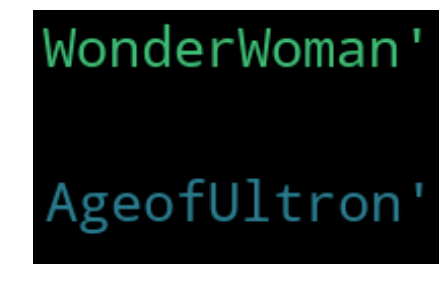

In [158]:
# generate plots for Most reviewed Movies in Rotten Tomatoes and Twitter. It shows wonderwoman and AgeOfUltron were the
#most reviewed movies
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [159]:
wordcloud1 = WordCloud(
        width = 2000,
        height = 1250,
        background_color = 'black',
        stopwords = stopwords_english
    ).generate(str(text1))

In [160]:
fig1 = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k'
    )

<Figure size 2880x2160 with 0 Axes>

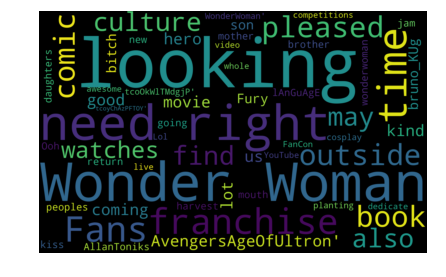

In [161]:
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)